# set up

In [54]:
import collections
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from scipy.optimize import minimize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn.functional as F

from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from safetensors.torch import save_model, load_model, load_file, safe_open

# TransformerWithHead inherets PreTrainedModel class: https://huggingface.co/docs/transformers/v4.40.1/en/main_classes/model#transformers.PreTrainedModel
# takes a vector of token ids as input, instead of a dict of {'input_ids': [], 'attention_mask': []} as with the AutoModel class
from weak_to_strong.model import TransformerWithHead

In [2]:
import sys
sys.path.insert(0, '../repmap')

from util import *

In [3]:
# print(f'available devices: {torch.cuda.device_count()}')
# print(f'current device: {torch.cuda.current_device()}')
# print(f'device name: {torch.cuda.get_device_name()}')

available devices: 1
current device: 0
device name: NVIDIA A100 80GB PCIe


In [3]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using: " + str(device))

using: cuda


# load models

In [4]:
# # load state_dict alone

# state_dict = load_file("../results/default/bs=32-dn=amaz_pola-e=2-ee=1000000-lp=0-l=xent-l=5e-05-ls=cosi_anne-mc=1024-ms=gpt2-nd=20000-ntd=10000-o=adam-s=0-twd=0/model.safetensors")

# state_dict['lm.transformer.h.1.attn.c_attn.weight']

In [5]:
# create pre-ft model

model_pre = TransformerWithHead.from_pretrained('gpt2').to(device)
# model_pre

In [6]:
# create post-ft model + load in state dict

model_post = TransformerWithHead.from_pretrained('gpt2').to(device)

load_model(model=model_post, filename="../results/default/bs=32-dn=amaz_pola-e=2-ee=1000000-lp=0-l=xent-l=5e-05-ls=cosi_anne-mc=1024-ms=gpt2-nd=20000-ntd=10000-o=adam-s=0-twd=0/model.safetensors")

model_post = model_post.to(device)
# model_post

# extract internal reps

## input processing

In [7]:
# input processing

def text2id(tokenizer, text):
    
    """ 
    tokenize input text and convert to input ids 
    - tokenizer: AutoTokenizer. pad_token required: tokenizer.pad_token = tokenizer.eos_token
    - text: size (B,) = (batch size,). each element is an input text string, e.g., ['test blah', 'blah blah']
    returns:
    - sentences: dict {'input_ids': [], 'attention_mask': []}. each value has shape (B, L): (batch_size, num token in sentence).
    """

    # tokens = tokenizer.tokenize(text)
    # input_ids = tokenizer.convert_tokens_to_ids(tokens)
    # input_ids = torch.tensor([input_ids]).to(device)
    # return input_ids

    # sentences is a dict of {'input_ids': [], 'attention_mask': []}
    sentences = tokenizer(
            text,
            return_tensors='pt',  # pt = pytorch style tensor
            padding=True
        ).to(device)
    
    return sentences

In [8]:
# sanity check

tokenizer_gpt2 = AutoTokenizer.from_pretrained('gpt2')
tokenizer_gpt2.pad_token = tokenizer_gpt2.eos_token

text = [
    "This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^", 
    "blah blah blahblah!"
]


ss = text2id(tokenizer_gpt2, text)
ss

{'input_ids': tensor([[ 1212,  2128,  2610,   373,  4950,     0,   632, 32281,   262,   264,
         24156,   287,   534,  2000,   523,   880,   314,   561,   664,   296,
           437,   340,   772,   284,   661,   508,  5465,   410,   312,    13,
           983,  2647,     0,   314,   423,  2826,   262,   983,  8750,    78,
          6372,   475,   503,   286,   477,   286,   262,  1830,   314,   423,
          1683,  2826,   340,   468,   262,  1266,  2647,     0,   632, 12983,
          1497,   422, 14897, 10586,   278,   290,  2753,   257, 34093,   372,
          2239,   351, 48612, 32497,   290,  5848,   913, 28127,   292,    13,
           632,   561, 14947,  2687,   508, 16609,   284,  6004,     0, 10563,
            62,    61],
        [ 2436,   993, 33367, 33367,  2436,   993,     0, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256

## rep extraction

In [9]:
# hook: https://web.stanford.edu/~nanbhas/blog/forward-hooks-pytorch/#method-3-attach-a-hook
# register_forward_hook: https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_forward_hook


# helper func
def get_activation(module_name, activations):

    """
    helper function for creating forward hooks.
    - module_name: name of module to register the hook onto & extract reps from.
    - activations: dict variable for the created hook to store extracted reps.
    """

    def hook(model, input, output):
        activations[module_name] = output[0].detach().to(device)  # 'output' is a tuple
    
    return hook


def extract_hidden_states(model, input_ids):

    """
    extract model internal reps with given inputs.
    - model: TransformerWithHead (inherets PreTrainedModel).
    - input_ids: shape (B, L): (batch_size, num token in sentence). use sentences['input_ids'] from text2id().
    returns:
    - activations: dict {layer name: activation}. each layer's activation has shape (B, L, D): (batch_size, num token in sentence, model dim)
    """

    # stores extracted model reps
    activations = {}  
    
    # register hooks on layers of choice
    hooks = []
    for name, module in model.transformer.named_modules():

        # set modules to register hooks on
        if isinstance(module, torch.nn.modules.Module):
            h = module.register_forward_hook(get_activation(name, activations))
            hooks.append(h)
    
    # pass input_ids through model for auto-extraction through hooks
    input_ids = input_ids.to(device)
    model.eval()
    with torch.no_grad():
        _ = model(input_ids)

    # detach hooks after use
    for h in hooks:
        h.remove()

    return activations

In [10]:
# sanity check
model_post(ss['input_ids'])

tensor([[-2.5364,  2.5364],
        [-0.7037,  0.7037]], device='cuda:0', grad_fn=<MmBackward0>)

In [11]:
# sanity check
activations = extract_hidden_states(model=model_post, input_ids=ss['input_ids'])  # dict: {layer name: activation}
activations['h.11'].shape

torch.Size([2, 92, 768])

## dataset & dataloader

In [19]:
# load huggingface datasets (train+test)

datasets = load_dataset("amazon_polarity").with_format("torch", device=device)
# datasets = datasets.shuffle(seed=42, buffer_size=10_000)  # shuffles the shards order + uses a shuffle buffer
datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 3600000
    })
    test: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 400000
    })
})

In [45]:
# create dataloaders from datasets
# use huggingface datasets with dataloader: https://huggingface.co/docs/datasets/en/loading

# set how many samples to use for train and test
N = {'train': 1000, 'test': len(datasets['test'])} 

dataloaders = collections.defaultdict()
for split in datasets.keys():
    dataloaders[split] = DataLoader(
        datasets[split].with_format("torch"),
        batch_size=10, 
        sampler=SubsetRandomSampler(list(range(N[split]))),
        shuffle=False
    )

In [46]:
# sanity check

next(iter(dataloaders['train']))
# next(iter(dataloaders['test']))

{'label': tensor([0, 0, 0, 1, 1, 1, 0, 0, 0, 1]),
 'title': ["Seth Kept this movie from getting a 'ZERO' star rating!!",
  'Not recommended!',
  'Not so much',
  'One of the best!',
  'Happy yet Dissapointed',
  'Awsome!!',
  'Does not work!',
  'Waste of money',
  'Please try another Hot Boy album...',
  'Great Game'],
 'content': ["A truly great example - of how terrible some movies have become!! Vulgar!! Offensive. Unnessisary nudity!! I usually love Adam Sandler - and can't believe he'd stoop so low in this role. Seth is highly likeable in this - but still swears and lowers himself as well. The woman who plays Adams 'romantic interest' is mostly great - but also stoops to swearing - blantant sexuality. The writing is the worst in this movie. This awful movie is 2 hours and 22 minutes long - but only feels like 5 hours. - And I could have spent my life doing something more interesting and exciting like watching paint dry or grass grow. I suggest skipping this movie altogether!! Trag

## main process

In [55]:
# helper func for pooling
def pooling(activations:dict, layer_name:str, attention_mask:torch.Tensor, method:str):

    # get unpooled activation from target layer
    activation_unpooled = activations[layer_name]  # (B, L, D): (batch_size, num token in sentence, model dim)
    

    # get pooled activation across tokens for each sentence
    if method == 'first':
        activation_pooled = activation_unpooled[:, 0, :]   # (B, D)

    elif method == 'last':
        activation_pooled = activation_unpooled[range(activation_unpooled.shape[0]), attention_mask.sum(dim=1) - 1, :]   # (B, D)

    elif method == 'mean':
        # mask padding tokens (where attention_mask is 0) with nan
        activation_unpooled_masked = activation_unpooled.masked_fill(
            attention_mask.unsqueeze(-1)==0,
            float('nan')
        )
        # max-pooling across tokens (L dimension) in each sentence
        activation_pooled = activation_unpooled_masked.nanmean(dim=1)   # (B, D)

    elif method == 'max':
        # mask padding tokens (where attention_mask is 0) with -inf
        activation_unpooled_masked = activation_unpooled.masked_fill(
            attention_mask.unsqueeze(-1)==0,
            float('-inf')
        )
        # max-pooling across tokens (L dimension) in each sentence
        activation_pooled, _ = activation_unpooled_masked.max(dim=1)   # (B, D)

    return activation_pooled  # (B, D): (batch_size, model dim)

In [59]:
# main extration process: get reps from chosen layers, pooling, append to be saved

def text2rep(dataloader, tokenizer, model, layer_names:list):

    """
    layer_names: a list of layers to extract activation from. e.g., ['h.10', 'h.11']
    """

    # iter through mini-batches in dataloader once to extract activation for all obs
    activations_all = collections.defaultdict(torch.Tensor)
    for batch in tqdm(dataloader):
        
        # convert text to input_ids + attention_mask
        sentences = text2id(tokenizer, batch['content'])  # dict: {input_ids: token ids, attention_mask: has token or padding}

        # extract activation from each layer
        activations = extract_hidden_states(
            model=model, 
            input_ids=sentences['input_ids']
        )  # dict: {layer name: activation}

        # keep activations from chosen layers + pooling
        for layer_name in layer_names:

            # get pooled activation
            activation_pooled = pooling(
                activations=activations, 
                layer_name=layer_name, 
                attention_mask=sentences['attention_mask'], 
                method='mean'
            )  # (B, D): (batch_size, model dim)
            
            # append
            activations_all[layer_name] = torch.cat(
                (activations_all[layer_name].to(device), activation_pooled), 
                dim=0
            )

    return activations_all

In [62]:
# example

gpt2_post = text2rep(
    dataloader=dataloaders['train'], 
    tokenizer=tokenizer_gpt2, 
    model=model_post, 
    layer_names=['h.10', 'h.11']
)

print(gpt2_post['h.10'].shape)
print(gpt2_post['h.10'])
print(gpt2_post['h.11'].shape)
print(gpt2_post['h.11'])

100%|██████████| 100/100 [00:03<00:00, 30.42it/s]

torch.Size([1000, 768])
tensor([[ 4.8404,  3.2834, -1.9144,  ..., -0.3921, -4.5961, -2.0894],
        [-3.3382,  1.8766, -1.7150,  ..., -2.1792,  0.0200, -0.2466],
        [-0.1736,  7.8676,  1.4048,  ..., -2.2731,  3.2617,  0.6957],
        ...,
        [ 3.0989,  7.2682,  1.5880,  ...,  0.6372,  1.3751,  2.3761],
        [ 0.2162,  7.8918, -2.6932,  ..., -1.6321,  2.0773,  1.9474],
        [ 0.6968,  7.0811,  2.0809,  ..., -2.0227,  2.1725,  1.4960]],
       device='cuda:0')
torch.Size([1000, 768])
tensor([[ 6.2053e+00,  7.5723e+00, -8.6395e+00,  ..., -3.7627e+00,
         -4.6410e+00, -8.0845e+00],
        [-5.0004e+00,  3.2120e+00, -2.7914e+00,  ...,  1.4626e+00,
          1.3013e+00, -2.1181e+00],
        [-1.2901e+00,  1.2382e+01,  5.4619e-01,  ..., -5.8366e-02,
          6.0298e+00, -1.5424e+00],
        ...,
        [ 2.8257e+00,  1.1173e+01, -1.1255e-02,  ...,  6.9910e+00,
          5.0105e+00, -6.7164e-02],
        [ 1.7586e+00,  1.0032e+01, -8.5106e+00,  ...,  1.5049e+00,
  

In [64]:
gpt2_pre = text2rep(
    dataloader=dataloaders['train'], 
    tokenizer=tokenizer_gpt2, 
    model=model_pre, 
    layer_names=['h.10', 'h.11']
)

print(gpt2_pre['h.10'].shape)
print(gpt2_pre['h.10'])
print(gpt2_pre['h.11'].shape)
print(gpt2_pre['h.11'])

100%|██████████| 100/100 [00:03<00:00, 28.66it/s]

torch.Size([1000, 768])
tensor([[ 0.7964, -1.4488, -2.6808,  ...,  3.4165,  0.9731, -2.0792],
        [ 1.8860, -0.3864, -2.4782,  ..., -0.5510,  0.1220, -0.9070],
        [ 0.7193,  0.7334, -4.1835,  ...,  1.1297,  2.5225,  1.6981],
        ...,
        [ 1.2478,  0.1239, -1.8912,  ..., -0.9093,  0.4406, -1.1400],
        [ 0.5011, -0.7305,  0.0511,  ..., -2.8094,  3.0355, -2.0916],
        [ 2.0093, -1.2039, -3.6110,  ..., -0.8403,  2.1377,  0.0653]],
       device='cuda:0')
torch.Size([1000, 768])
tensor([[ 1.8162, -1.5948, -3.9047,  ...,  4.2885,  0.3454, -1.6128],
        [ 2.3710, -0.4046, -4.0925,  ..., -0.2042, -0.1911, -1.6371],
        [ 0.7923,  1.7717, -4.5742,  ...,  1.6722,  2.8459,  0.5418],
        ...,
        [ 1.8438, -0.0164, -2.0520,  ..., -0.3600,  0.7284, -1.4890],
        [ 0.1838, -0.0427,  0.3320,  ..., -3.4965,  4.0038, -2.7074],
        [ 1.9942, -0.8328, -3.9446,  ...,  0.8062,  3.1185, -1.6922]],
       device='cuda:0')


# exploratory visuals

In [79]:
def plot_activation_changes(activation1, activation2, method='PCA', components=2, title=''):

    """
    Visualize changes in activations using PCA or t-SNE.

    Parameters:
    activation1/activation2: Activations to be compared. shape (N, D) = (N obs, model dim)
    method (str): 'PCA' or 't-SNE', the method to use for dimensionality reduction.
    components (int): Number of components for the dimensionality reduction.
    """

    # copy tensors from cuda to host memory
    activation1, activation2 = activation1.cpu(), activation1.cpu()
    
    # Concatenate data from both states for unified transformation in PCA/t-SNE
    data_combined = np.concatenate([activation1, activation2], axis=0)
    
    if method == 'PCA':
        reducer = PCA(n_components=components)
    elif method == 't-SNE':
        reducer = TSNE(n_components=components, learning_rate='auto', init='random')
    else:
        raise ValueError("Unsupported dimensionality reduction method")
    
    # Fit and transform the data
    reduced_data = reducer.fit_transform(data_combined)
    
    # Split the transformed data
    reduced_data_pre = reduced_data[:activation1.shape[0]]
    reduced_data_post = reduced_data[activation1.shape[0]:]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_data_pre[:, 0], reduced_data_pre[:, 1], c='blue', alpha=0.2, label='Pre-Finetuning')
    plt.scatter(reduced_data_post[:, 0], reduced_data_post[:, 1], c='red', alpha=0.2, label='Post-Finetuning')
    plt.title(f'{title} - {method} Visualization')
    plt.xlabel(f'{method} Component 1')
    plt.ylabel(f'{method} Component 2')
    plt.legend()
    plt.show()

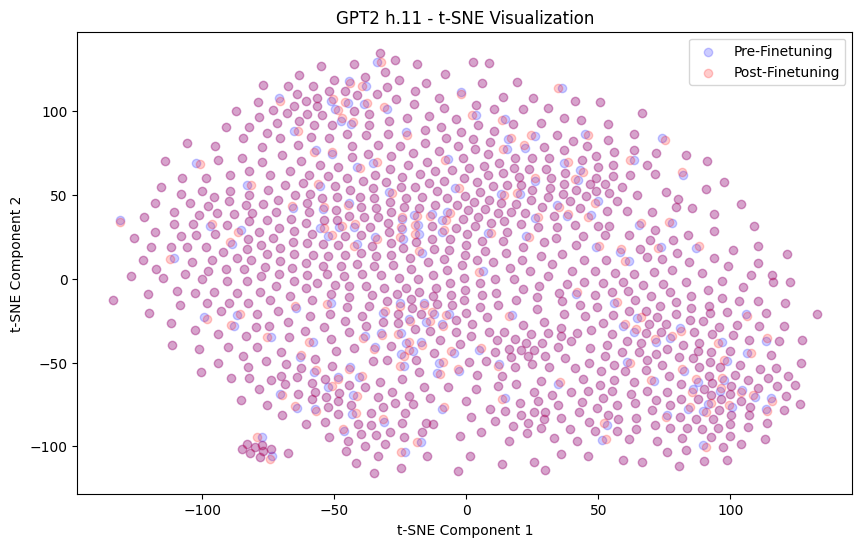

In [80]:
plot_activation_changes(activation1=gpt2_pre['h.11'], activation2=gpt2_post['h.11'], method='t-SNE', title='GPT2 h.11')

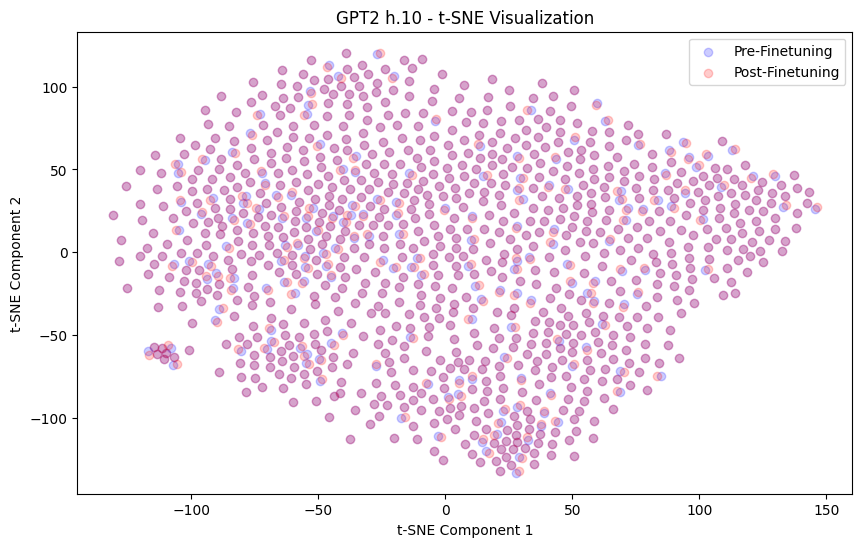

In [81]:
plot_activation_changes(activation1=gpt2_pre['h.10'], activation2=gpt2_post['h.10'], method='t-SNE', title='GPT2 h.10')

# find transformation & infer task rep

## cross-time

In [ ]:
def torch_loss_function(A, delta, lambda_x, lambda_x_tilde):
    """
    Computes the loss for a batch of data.

    Args:
    A (torch.Tensor): The affine transformation matrix.
    delta (torch.Tensor): The rank-one update vector.
    lambda_x (torch.Tensor): Pre-finetuning activations (batch).
    lambda_x_tilde (torch.Tensor): Post-finetuning activations (batch).

    Returns:
    torch.Tensor: The computed loss.
    """
    # Compute the affine transformation and add delta
    transformed = torch.mm(lambda_x, A) + delta
    # Calculate the Frobenius norm of the difference, scaled by the number of samples
    loss = torch.norm(transformed - lambda_x_tilde, p='fro') ** 2 / lambda_x.size(0)
    return loss

def optimize_Adelta(pre_ft_activations, post_ft_activations, batch_size, lr=1e-3, tol=1e-5, max_iter=20000):
    """
    Optimizes A and delta parameters using the provided pre and post-finetuning activations.

    Args:
    pre_ft_activations (np.array): Pre-finetuning activations.
    post_ft_activations (np.array): Post-finetuning activations.
    dim (int): The dimensionality of each feature vector.
    batch_size (int): The size of each batch for optimization.
    lr (float): Learning rate for the optimizer.
    tol (float): Tolerance for convergence.
    max_iter (int): Maximum number of iterations.

    Returns:
    Tuple[np.array, np.array]: Optimized A and delta.
    """
    dim = pre_ft_activations[0].shape[1]
    # Convert numpy arrays to torch tensors
    pre_ft_activations_tensor = torch.tensor(pre_ft_activations, dtype=torch.float32)
    post_ft_activations_tensor = torch.tensor(post_ft_activations, dtype=torch.float32)
    
    # Initialize A and delta as torch tensors
    A = nn.Parameter(torch.eye(dim, requires_grad=True))
    delta = nn.Parameter(torch.zeros(1, dim, requires_grad=True))

    # Use the Adam optimizer
    optimizer = optim.Adam([A, delta], lr=lr)

    previous_loss = float('inf')
    for iteration in range(max_iter):
        for i in range(0, len(pre_ft_activations), batch_size):
            optimizer.zero_grad()
            batch_pre_ft = pre_ft_activations_tensor[i:i+batch_size].squeeze(1)
            batch_post_ft = post_ft_activations_tensor[i:i+batch_size].squeeze(1)
#             print(batch_pre_ft.shape)
#             print(batch_post_ft.shape)
            loss = torch_loss_function(A, delta, batch_pre_ft, batch_post_ft)
            loss.backward()
            optimizer.step()

            current_loss = loss.item()
            if iteration % 50 == 0 and i == 0:  # Print the loss for the first batch every 10 iterations
                print(f"Iteration {iteration}, Loss: {current_loss:.6f}")
            
            if abs(previous_loss - current_loss) < tol:
                print("Convergence criterion met.")
                return A.detach().numpy(), delta.detach().numpy()
            previous_loss = current_loss

    print("Optimization finished.")
    return A.detach().numpy(), delta.detach().numpy()

## cross-model

# gt task rep through linear probing

# legacy

In [2]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize


# The objective function to be minimized. fun(x, *args) -> float. where x is a 1-D array with shape (n,) and args is a tuple of the fixed parameters needed to completely specify the function.
def loss_crosstime(params, *inputs):

    # inputs: (lam_x, lam_x_tilde)
    lambda_x = inputs[0]  # pre finetuning
    lambda_x_tilde = inputs[1]  # post finetuning

    # print(lambda_x.shape, lambda_x_tilde.shape)

    n = lambda_x.shape[0]
    dim = lambda_x.shape[1]
    A_len = dim**2

    # reshape params into the affine matrix 'A' and the rank-one vector 'delta'
    A = params[:A_len].reshape(dim, dim)
    delta = params[A_len:]

    # print(A.shape, delta.shape)
    
    # loss function
    # return np.linalg.norm((lambda_x @ A + delta) - lambda_x_tilde) ** 2 / n
    return np.linalg.norm((lambda_x @ A + delta) - lambda_x_tilde)

In [10]:
# set model rep dimension
D = 1024

In [11]:
A_test = torch.rand(D, D)

In [12]:
# A_test

In [13]:
# sanity check with rand pre- and post-ft activations
activation_pre = torch.rand(2000, D) * 10
activation_post = activation_pre @ A_test + 1

In [14]:
activation_pre

tensor([[5.0852, 4.5845, 4.4022,  ..., 5.7777, 8.1204, 7.9563],
        [5.9564, 6.1956, 1.9700,  ..., 3.4701, 4.1428, 5.4585],
        [4.3740, 2.7451, 2.8656,  ..., 6.1040, 9.8621, 4.0515],
        ...,
        [5.7783, 4.5912, 4.4352,  ..., 0.7943, 7.0794, 7.7217],
        [8.4676, 4.1433, 1.7271,  ..., 7.3549, 0.9463, 0.3036],
        [8.0331, 3.2713, 7.2054,  ..., 6.1734, 9.5217, 7.1809]])

In [15]:
activation_post

tensor([[2649.8684, 2634.0996, 2599.2061,  ..., 2748.7581, 2683.0334,
         2683.7681],
        [2457.1372, 2386.0737, 2462.8872,  ..., 2539.3291, 2454.9287,
         2493.5898],
        [2591.9475, 2548.4307, 2517.2449,  ..., 2709.2290, 2565.3223,
         2623.1562],
        ...,
        [2575.2344, 2521.2871, 2509.0493,  ..., 2652.2019, 2544.8911,
         2592.8931],
        [2514.9346, 2448.4187, 2473.8452,  ..., 2573.1196, 2511.2644,
         2514.4683],
        [2702.2432, 2658.6689, 2660.5825,  ..., 2787.4670, 2680.5112,
         2762.6343]])

In [16]:
# initial guess for params
initial_guess = np.ones(D**2+D, dtype="float32")

# perform the optimization
result = minimize(fun=loss_crosstime, x0=initial_guess, args=(activation_pre, activation_post), method='BFGS')

# extract the optimal values
A_opt = result.x[:D**2].reshape(D, D)
delta_opt = result.x[D**2:]

MemoryError: Unable to allocate 8.02 TiB for an array with shape (1049600, 1049600) and data type float64

In [17]:
# A_opt

In [18]:
# delta_opt

In [19]:
# np.linalg.norm(A_opt - np.array(A_test))

In [20]:
# np.linalg.norm(A_test)